### Generating data 

In [14]:
# We will generate a dataset simulating the daily closing prices of a hypothetical stock over a period of time.
# The dataset will contain 10,000 data points, with some missing values to simulate the need for interpolation.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Simulate daily closing stock prices with random walk + noise
np.random.seed(42)  # For reproducibility
dates = pd.date_range(start="2000-01-01", periods=10000)
prices = np.random.randn(10000).cumsum() + 100  # Start around 100 and perform a random walk
prices += np.random.randn(10000) * 2  # Adding some noise

# Introduce some NaNs to simulate missing data
missing_indices = np.random.choice(10000, size=500, replace=False)  # Randomly choose 500 points to be missing
prices[missing_indices] = np.nan

# Create DataFrame
stock_df = pd.DataFrame(data={"Date": dates, "Price": prices})

stock_df.head(), stock_df.isnull().sum()

(        Date       Price
 0 2000-01-01   99.139725
 1 2000-01-02   99.747451
 2 2000-01-03   99.811376
 3 2000-01-04  102.750004
 4 2000-01-05  104.689372,
 Date       0
 Price    500
 dtype: int64)

In [15]:
stock_df

,Date,Price
0,2000-01-01,99.139725
1,2000-01-02,99.747451
2,2000-01-03,99.811376
3,2000-01-04,102.750004
4,2000-01-05,104.689372
...,...,...
9995,2027-05-14,NaN
9996,2027-05-15,80.960062
9997,2027-05-16,78.256720
9998,2027-05-17,81.422837


In [16]:
stock_df.isnull().sum()

Date       0
Price    500
dtype: int64

### Intepolating the Missing Data

In [17]:
from scipy.interpolate import interp1d

# Interpolation: Fill in missing values using linear interpolation

# First, we need to extract the indices where the data is not missing to use for interpolation
valid_indices = np.where(~np.isnan(prices))[0]
valid_prices = prices[valid_indices]

# Create an interpolation function based on valid data points
linear_interp = interp1d(valid_indices, valid_prices, kind='linear', fill_value="extrapolate")

# Now, apply this function to all indices, including those of missing data, to fill them in
all_indices = np.arange(0, len(prices))
filled_prices = linear_interp(all_indices)

# Update the DataFrame with interpolated prices
stock_df['Price_Filled'] = filled_prices

# Check if there are any NaNs left in the filled prices
nan_check_after_interpolation = stock_df['Price_Filled'].isnull().sum()

stock_df.head(), nan_check_after_interpolation

(        Date       Price  Price_Filled
 0 2000-01-01   99.139725     99.139725
 1 2000-01-02   99.747451     99.747451
 2 2000-01-03   99.811376     99.811376
 3 2000-01-04  102.750004    102.750004
 4 2000-01-05  104.689372    104.689372,
 0)

In [18]:
stock_df

,Date,Price,Price_Filled
0,2000-01-01,99.139725,99.139725
1,2000-01-02,99.747451,99.747451
2,2000-01-03,99.811376,99.811376
3,2000-01-04,102.750004,102.750004
4,2000-01-05,104.689372,104.689372
...,...,...,...
9995,2027-05-14,NaN,80.883908
9996,2027-05-15,80.960062,80.960062
9997,2027-05-16,78.256720,78.256720
9998,2027-05-17,81.422837,81.422837


In [19]:
stock_df.isnull().sum()

Date              0
Price           500
Price_Filled      0
dtype: int64

### Visualizing the Interpolated Missing Data

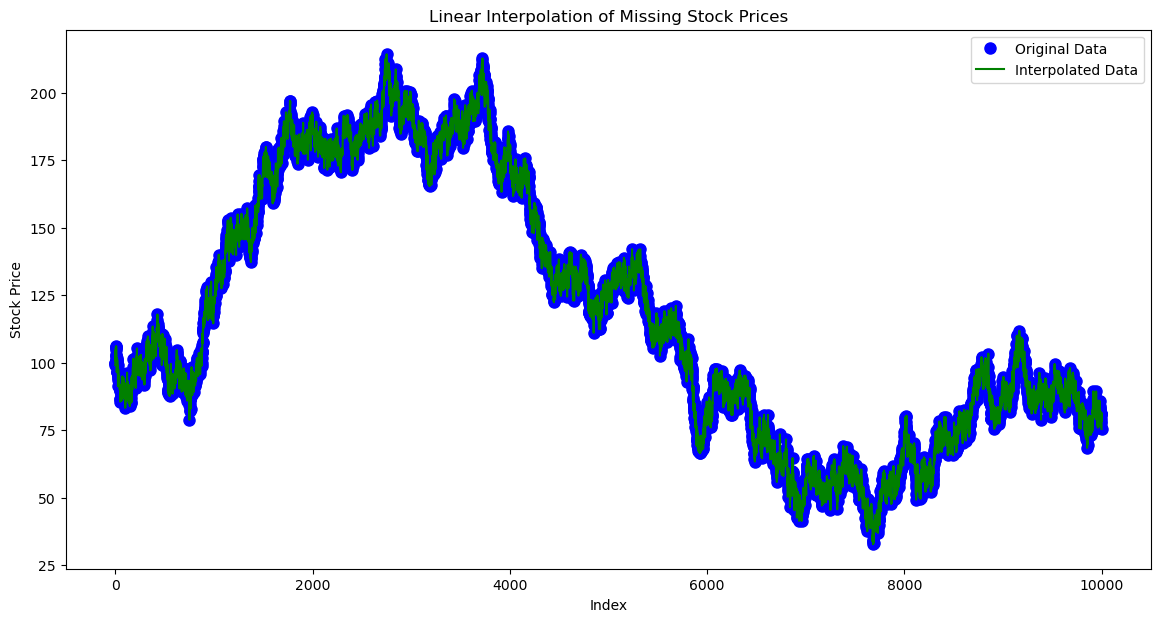

In [20]:
# Plotting the original and interpolated data with blue dots for the original data points

plt.figure(figsize=(14, 7))

# Only plot the original data points where the data is not NaN (missing)
plt.plot(stock_df.index[~stock_df['Price'].isnull()], stock_df['Price'][~stock_df['Price'].isnull()], 'bo', label='Original Data', markersize=8)

# Plot the interpolated data
plt.plot(stock_df.index, stock_df['Price_Filled'], 'g-', label='Interpolated Data')

plt.title('Linear Interpolation of Missing Stock Prices')
plt.xlabel('Index')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

### Building the Regression Model

/Users/dipanshuksh/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


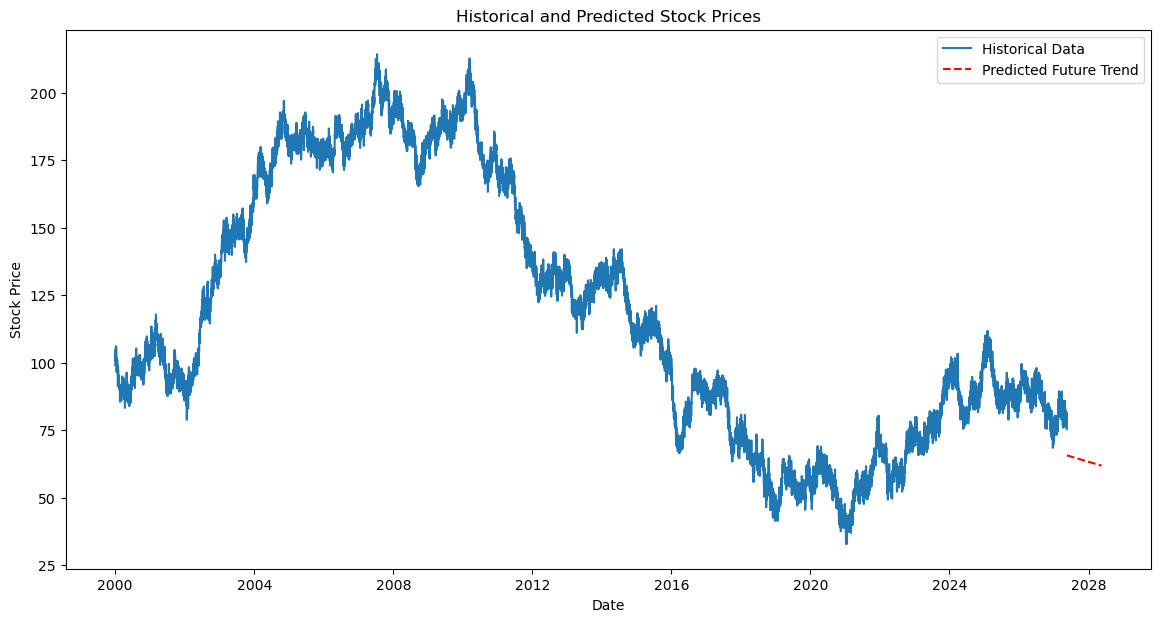

Training MSE: 1347.2578495934968, Training R²: 0.4067388319035873
Testing MSE: 1363.66277554336, Testing R²: 0.3955817175712897
        Date  Predicted_Price
0 2027-05-19        65.638524
1 2027-05-20        65.627998
2 2027-05-21        65.617473
3 2027-05-22        65.606947
4 2027-05-23        65.596422


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt

# Convert Date to ordinal to use as a feature for regression
stock_df['Date_Ordinal'] = stock_df['Date'].apply(lambda x: x.toordinal())

# Split the data into training and testing sets
X = stock_df[['Date_Ordinal']]
y = stock_df['Price_Filled']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the training and testing sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate performance metrics for both sets
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Predict future trends beyond the dataset
future_dates = pd.date_range(start=stock_df['Date'].iloc[-1] + pd.Timedelta(days=1), periods=365)
future_dates_ordinal = future_dates.to_series().apply(lambda x: x.toordinal()).values.reshape(-1, 1)

# Predict the next year's stock prices
future_prices = model.predict(future_dates_ordinal)

# Append predictions to the DataFrame for plotting
predictions_df = pd.DataFrame(data={'Date': future_dates, 'Predicted_Price': future_prices})

# Plot the historical and predicted stock prices
plt.figure(figsize=(14, 7))
plt.plot(stock_df['Date'], stock_df['Price_Filled'], label='Historical Data')
plt.plot(predictions_df['Date'], predictions_df['Predicted_Price'], 'r--', label='Predicted Future Trend')
plt.title('Historical and Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Print MSE and R² for both training and testing sets, and display first few rows of predictions_df
print(f"Training MSE: {mse_train}, Training R²: {r2_train}")
print(f"Testing MSE: {mse_test}, Testing R²: {r2_test}")
print(predictions_df.head())